# 3 - Análise Exploratória de Séries Temporais - Faturamento do produto `alimenticio`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `alimenticio`.

In [11]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'alimenticio'
fat = tswide[analise_produto].dropna()

In [4]:
fat

date
2009-12-01    1.006195e+09
2010-01-01    9.986980e+08
2010-02-01    9.994182e+08
2010-03-01    9.900000e+08
2010-04-01    9.942075e+08
                  ...     
2021-06-01    1.887381e+09
2021-07-01    1.872678e+09
2021-08-01    1.899408e+09
2021-09-01    1.975179e+09
2021-10-01    1.990000e+09
Freq: MS, Name: alimenticio, Length: 143, dtype: float64

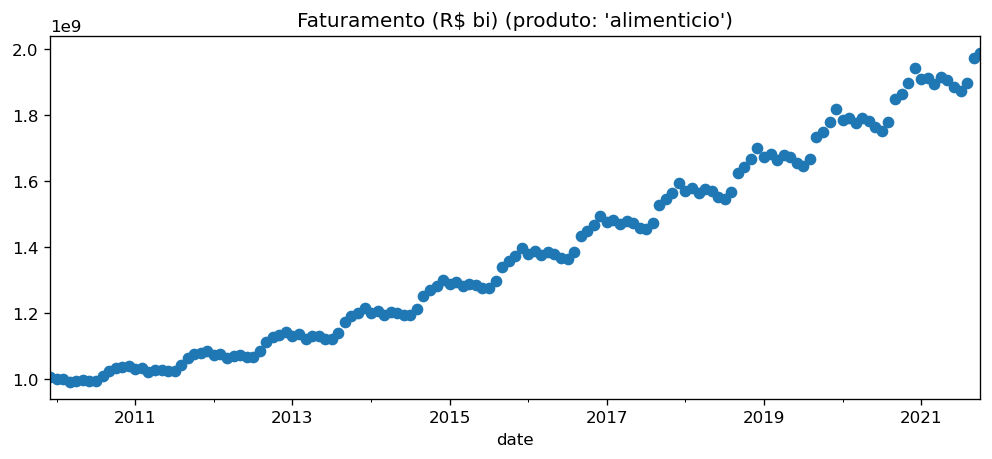

In [5]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ bi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória - produto `alimenticio`

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [6]:
fat.describe()

count    1.430000e+02
mean     1.387476e+09
std      2.965446e+08
min      9.900000e+08
25%      1.122228e+09
50%      1.364441e+09
75%      1.644394e+09
max      1.990000e+09
Name: alimenticio, dtype: float64

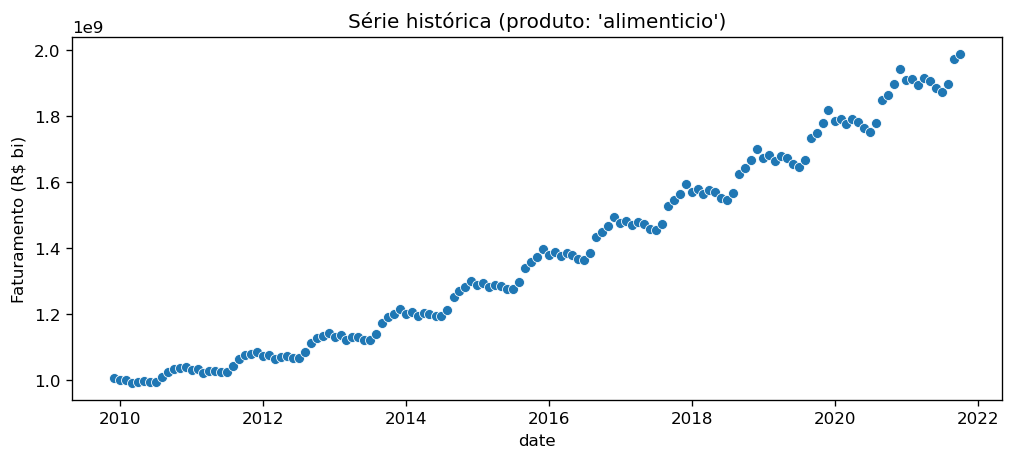

In [7]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ bi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

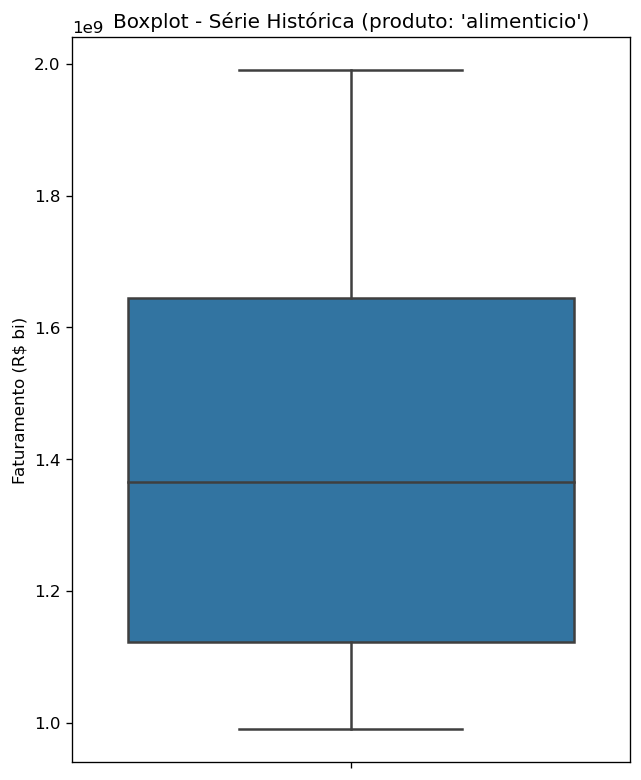

In [8]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

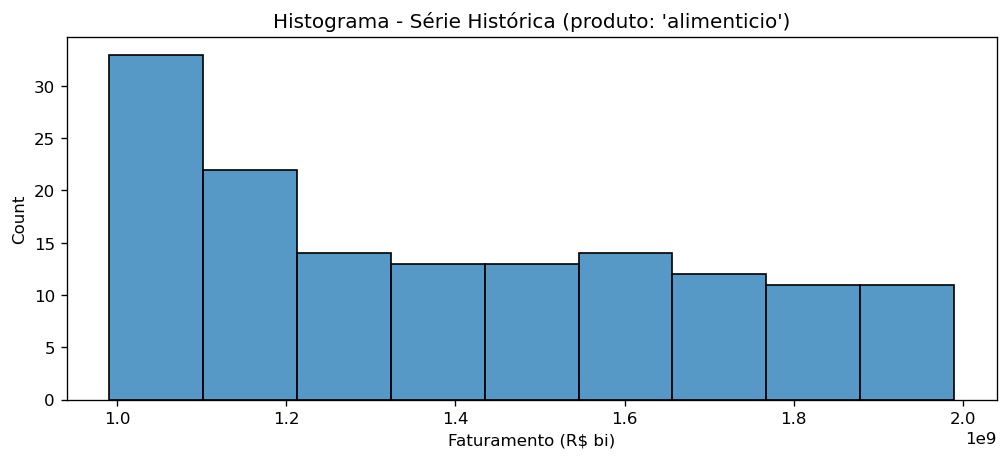

In [9]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ bi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [10]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.754887e+09
std      1.276560e+08
min      1.545698e+09
25%      1.665024e+09
50%      1.765983e+09
75%      1.872678e+09
max      1.990000e+09
Name: alimenticio, dtype: float64

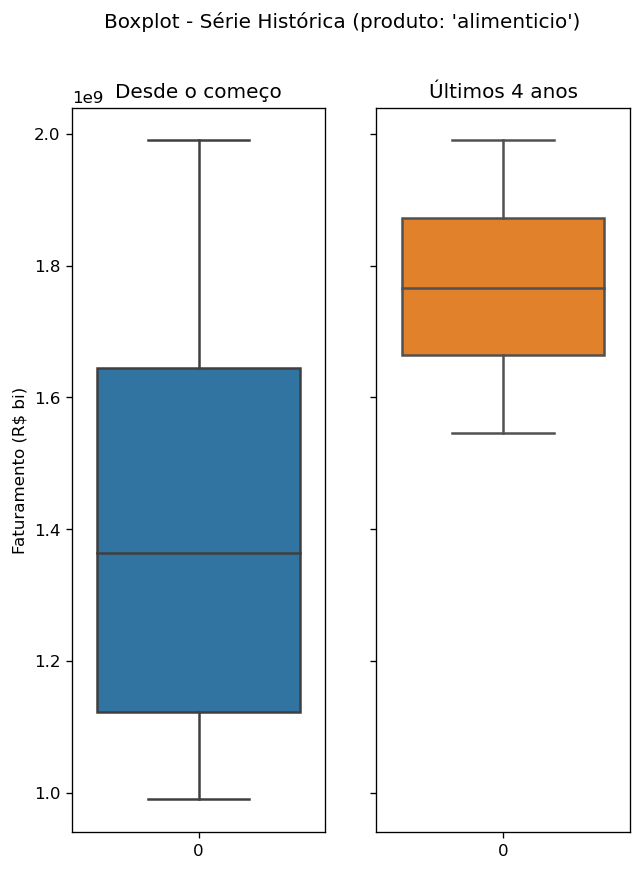

In [11]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

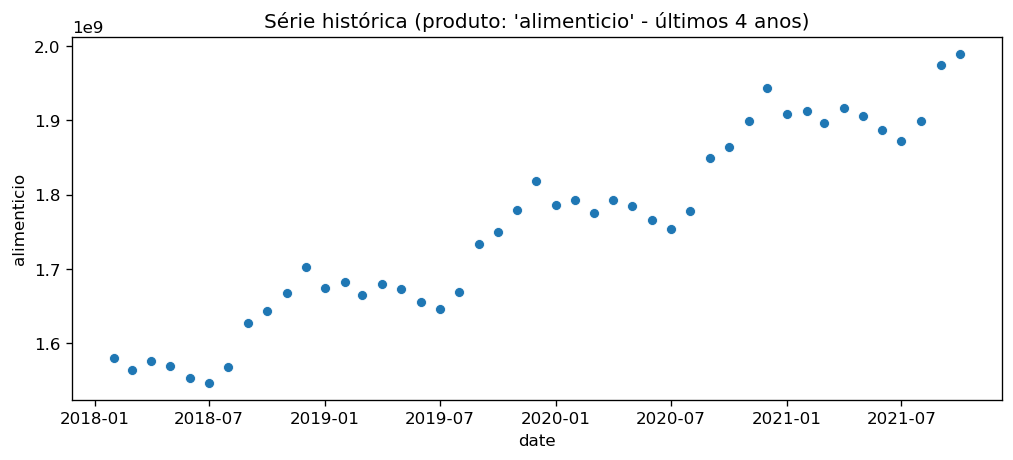

In [12]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

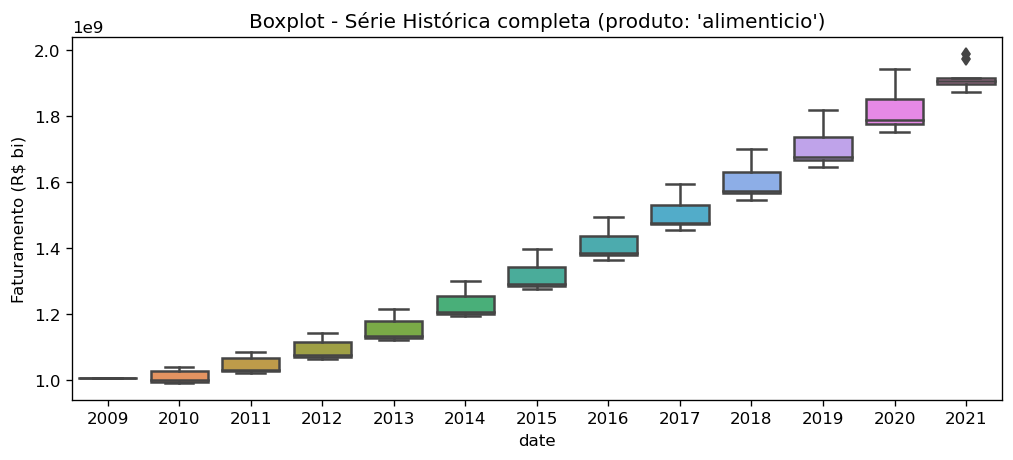

In [13]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

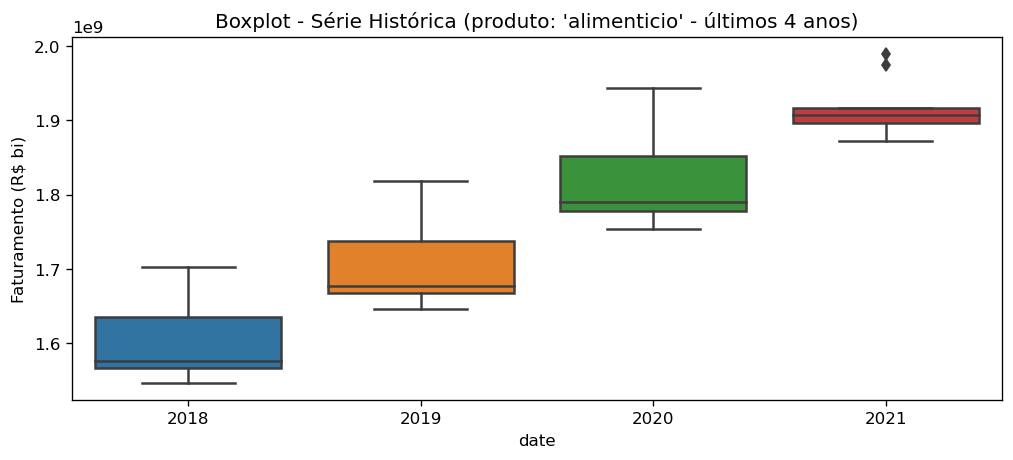

In [14]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

Observamos o mesmo efeito que no faturamento total - há aparentes *outliers* em 2021 por conta de a série neste ano não estar completa.

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [15]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

In [16]:
testedf = adfuller(fat)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 99.613% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

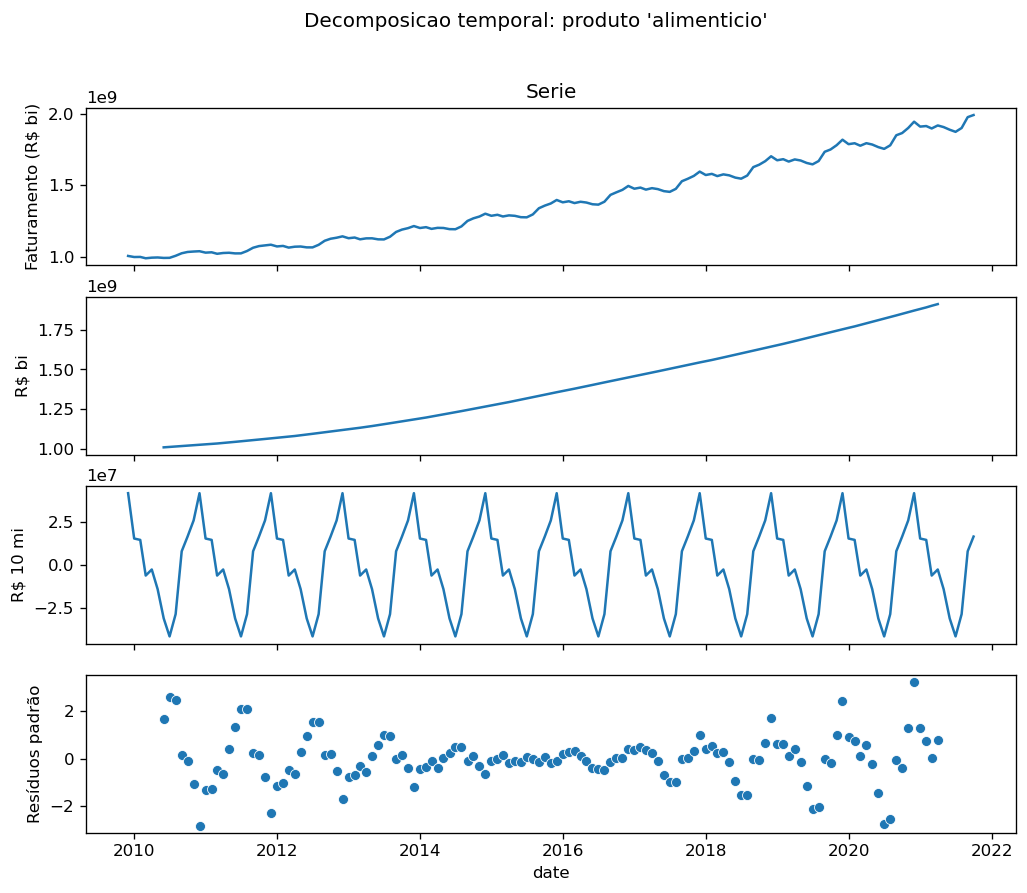

In [17]:
decomps[analise_produto] = seasonal_decompose(fat)
decomp = decomps[analise_produto]

fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

ts_filtro = tsd[analise_produto]
i = i_palette[analise_produto]
c = seaborn_palette[i]

sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
axs[0].set_title('Serie')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.lineplot(data = decomp.trend, ax = axs[1], color = c)
axs[1].set_ylabel('R$ bi')

sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)
axs[2].set_ylabel('R$ 10 mi')

resid_standard = (decomp.resid - decomp.resid.mean()) / decomp.resid.std()
sns.scatterplot(data = resid_standard, ax = axs[3], color = c)
axs[3].set_ylabel('Resíduos padrão')

fig.suptitle(f"Decomposicao temporal: produto '{analise_produto}'")
plt.show()

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos não estão distribuídos aleatoriamente (apresentam um padrão oscilatório).

É necessário um modelo mais complexo.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

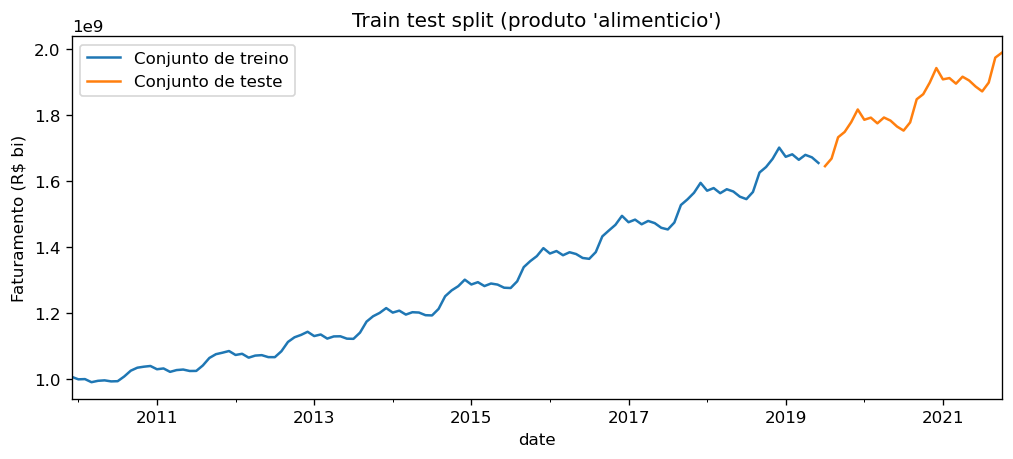

In [19]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

train_test_split_idx = int(fat.shape[0] * 0.8 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

In [20]:
train_test_split_idx

115

De cara já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) devem ser ao menos 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

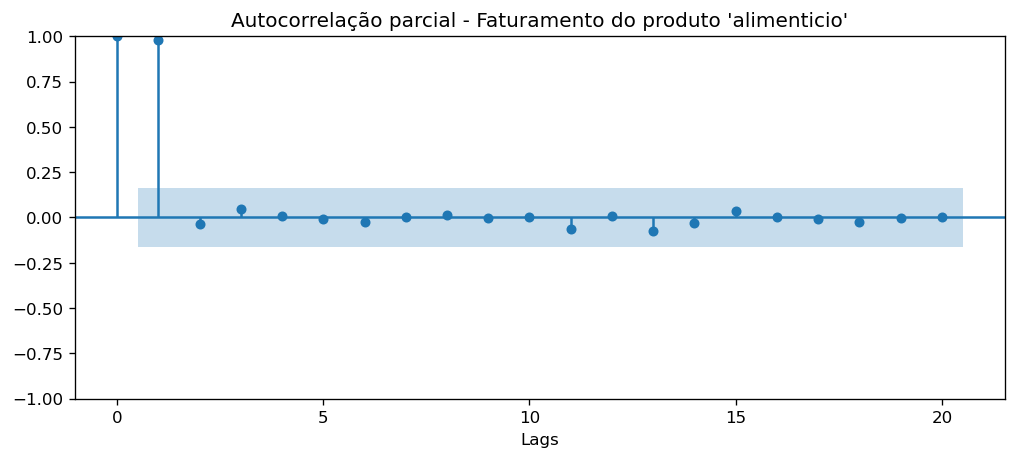

In [4]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d = 1$.

In [29]:
arimas = {}
arimas[analise_produto] = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 2, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,2,1)[12]             : AIC=2670.983, Time=1.79 sec
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=2665.566, Time=0.04 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=2664.994, Time=1.58 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=2663.310, Time=0.09 sec
 ARIMA(1,2,0)(0,2,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=2666.945, Time=1.11 sec
 ARIMA(2,2,0)(0,2,0)[12]             : AIC=2667.290, Time=0.24 sec
 ARIMA(1,2,1)(0,2,0)[12]             : AIC=2667.379, Time=0.15 sec
 ARIMA(0,2,1)(0,2,0)[12]             : AIC=2663.779, Time=0.22 sec
 ARIMA(2,2,1)(0,2,0)[12]             : AIC=2669.057, Time=0.38 sec
 ARIMA(1,2,0)(0,2,0)[12] intercept   : AIC=2665.300, Time=0.11 sec

Best model:  ARIMA(1,2,0)(0,2,0)[12]          
Total fit time: 8.513 seconds


In [35]:
arimas[analise_produto] = ARIMA(order = (1, 2, 0), seasonal_order=(0, 2, 0, 12), with_intercept = False, start_params = ()).fit(y = fat_train)

In [36]:
arimas[analise_produto].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 2, 0)x(0, 2, 0, 12)   Log Likelihood               -1329.655
Date:                            Wed, 17 Nov 2021   AIC                           2663.310
Time:                                    14:21:34   BIC                           2668.287
Sample:                                         0   HQIC                          2665.316
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009      0.045      0.020      0.984      -0.087       0.089
sigma2      5.075e+11   5.86e-15   8.66e+25      0.000    5.08e+11    5.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.96   Skew:                             0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+42. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

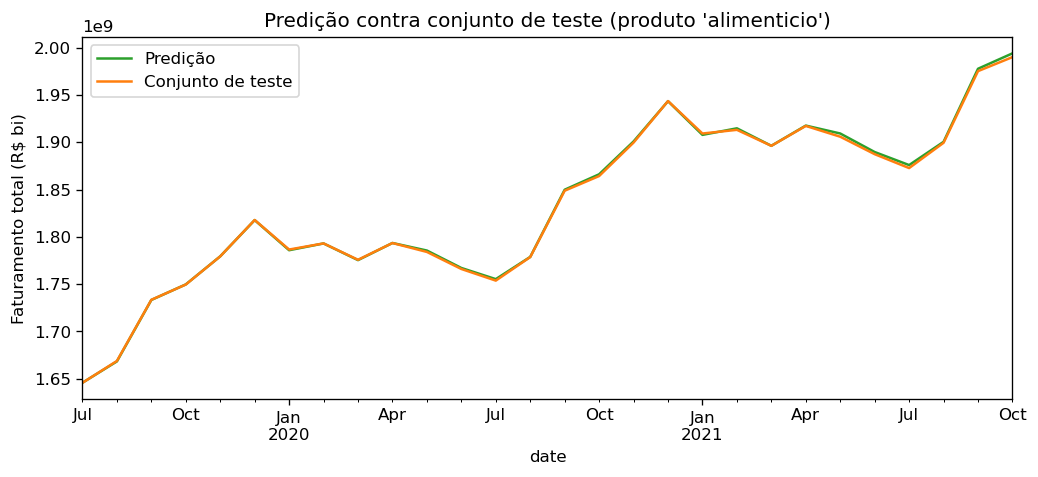

In [37]:
n_test_periods = fat_test.shape[0]
arr_preds = arimas[analise_produto].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = fat_test.index[0], periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

palette = sns.color_palette(None, 4)
preds.plot(label = 'Predição', color = palette[2])
fat_test.plot(label = 'Conjunto de teste', color = palette[1])

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f"Predição contra conjunto de teste (produto '{analise_produto}')")
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [38]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = arimas[analise_produto].df_model()
)

py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
    MAPE: 0.058%
    RMSE: 1.553e+06
     MAE: 1.087e+06
      R²: 99.967%
 R² adj.: 99.967%
